In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [3]:
df = pd.read_csv('/content/drive/MyDrive/experiments/alifbanktest/credit_train.csv', sep=';', encoding="cp1251", index_col='client_id')
blindSet = pd.read_csv('/content/drive/MyDrive/experiments/alifbanktest/credit_test.csv', sep=';', encoding="cp1251", index_col='client_id')

In [4]:
df.head(5)

,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg
client_id,,,,,,,,,,,,,,
1,M,48,MAR,UMN,"59998,00",10,1.6,"0,770249",GRD,КРАСНОДАРСКИЙ КРАЙ,30000.0,1.0,1.0,0
2,F,28,MAR,UMN,"10889,00",6,1.1,"0,248514",GRD,МОСКВА,43000.0,2.0,0.0,0
3,M,32,MAR,SPC,"10728,00",12,1.1,"0,459589",SCH,ОБЛ САРАТОВСКАЯ,23000.0,5.0,0.0,0
4,F,27,DIV,SPC,"12009,09",12,1.1,"0,362536",GRD,ОБЛ ВОЛГОГРАДСКАЯ,17000.0,2.0,0.0,0
5,M,45,MAR,SPC,"16908,89",10,1.1,"0,421385",SCH,ЧЕЛЯБИНСКАЯ ОБЛАСТЬ,25000.0,1.0,0.0,0


In [5]:
df['score_shk'].replace(',', '.', regex=True, inplace=True)
df['credit_sum'].replace(',', '.', regex=True, inplace=True)
df = df.astype({'credit_sum': float, 'score_shk': float})

# 1. EDA

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 170746 entries, 1 to 170746
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   gender                170746 non-null  object 
 1   age                   170746 non-null  int64  
 2   marital_status        170746 non-null  object 
 3   job_position          170746 non-null  object 
 4   credit_sum            170746 non-null  float64
 5   credit_month          170746 non-null  int64  
 6   tariff_id             170746 non-null  float64
 7   score_shk             170746 non-null  float64
 8   education             170746 non-null  object 
 9   living_region         170554 non-null  object 
 10  monthly_income        170745 non-null  float64
 11  credit_count          161516 non-null  float64
 12  overdue_credit_count  161516 non-null  float64
 13  open_account_flg      170746 non-null  int64  
dtypes: float64(6), int64(3), object(5)
memory usage: 19.

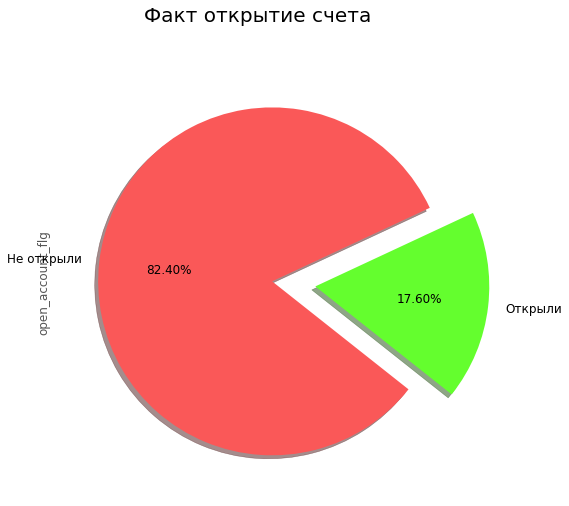

In [7]:
f, ax = plt.subplots(1,1, figsize=(16,8))

colors = ["#FA5858", "#64FE2E"]
labels ="Не открыли", "Открыли"

plt.suptitle('Факт открытие счета', fontsize=20)

df["open_account_flg"].value_counts().plot.pie(explode=[0,0.25], autopct='%1.2f%%', ax=ax, shadow=True, colors=colors, 
                                             labels=labels, fontsize=12, startangle=25)


plt.show()

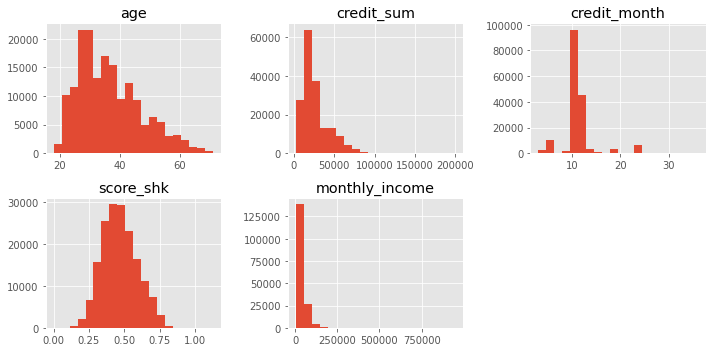

In [8]:
numerical = ['age', 'credit_sum', 'credit_month', 'score_shk', 'monthly_income']
df[numerical].hist(bins=20, layout=(2, 3), figsize=(10,5))

plt.tight_layout()
plt.show()

In [9]:
#Кол-во None значений в датасете
df.isnull().sum()

gender                     0
age                        0
marital_status             0
job_position               0
credit_sum                 0
credit_month               0
tariff_id                  0
score_shk                  0
education                  0
living_region            192
monthly_income             1
credit_count            9230
overdue_credit_count    9230
open_account_flg           0
dtype: int64

In [10]:
df.nunique()

gender                      2
age                        54
marital_status              5
job_position               18
credit_sum              42769
credit_month               31
tariff_id                  32
score_shk               16280
education                   5
living_region             301
monthly_income           1591
credit_count               21
overdue_credit_count        4
open_account_flg            2
dtype: int64

In [11]:
# Всего 170746 человек в датасете
df.shape

(170746, 14)

In [12]:
df.mean(numeric_only=True)

age                        36.497283
credit_sum              26095.047799
credit_month               10.980749
tariff_id                   1.323900
score_shk                   0.469473
monthly_income          40138.288354
credit_count                2.107308
overdue_credit_count        0.046070
open_account_flg            0.176028
dtype: float64

### Describe summary
1. Средний возраст клиентов в датасете 36 лет
2. Средняя сумма кредита 26 095 рублей
2. Средний срок кредита 11 месяцев (краткосрочные)
3. Средний доход клиентов 40 тысю рублей
5. Средний score 0.469
6. Средний клиент уже имеет 2 кредита

### Gender
<i> Распределение <b>gender</b> в датасете

In [ ]:
#Сколько мужчин и женщин
df.gender.value_counts()

F    88697
M    82049
Name: gender, dtype: int64

In [ ]:
#Их процентное соотношение
df['gender'].value_counts(normalize=True).mul(100)

F    51.946751
M    48.053249
Name: gender, dtype: float64

In [ ]:
def plotDistribution(column, title):
  norm_target = (
      df
      [column]
      .value_counts(normalize=True)
      .mul(100)
      .rename('percent')
      .reset_index()
  )

  plt.figure(figsize=(8, 7))

  ax = sns.barplot(
      x='index',
      y='percent',
      data=norm_target
  )

  for p in ax.patches:
      percentage = '{:.1f}%'.format(p.get_height())
      ax.annotate(
          percentage,  
          (p.get_x() + p.get_width() / 2., p.get_height()), 
          ha='center', 
          va='center',
          xytext=(0, 10),
          textcoords='offset points', 
          fontsize=14
      )

  plt.title(f'{title} distribution', fontsize=16)
  plt.xlabel(f'{title.lower()}', fontsize=12)
  plt.ylabel('Percentage', fontsize=12)

  plt.xticks(fontsize=12)
  plt.yticks(fontsize=12);

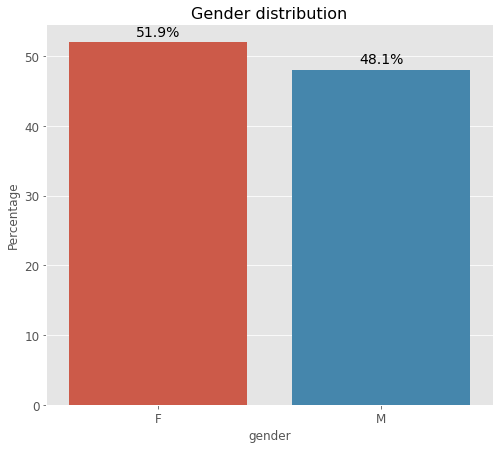

In [ ]:
plotDistribution('gender', 'Gender')

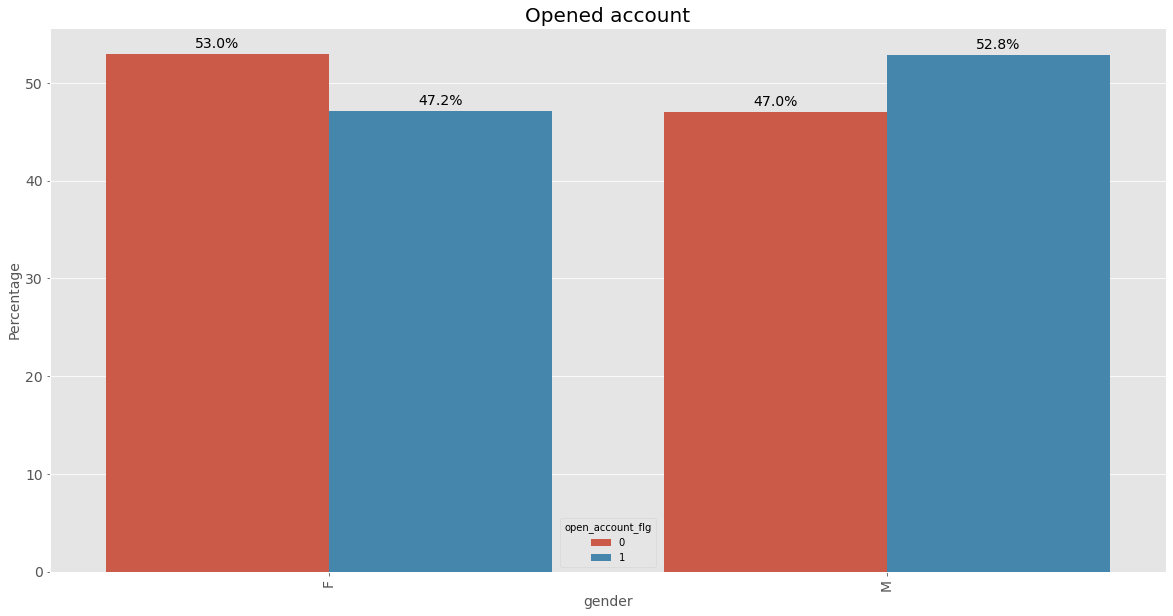

In [ ]:
# Факт открытие счета по гендерному распределению
plt.figure(figsize=(20, 10))

educ_def = (df.groupby(['open_account_flg'])['gender']
            .value_counts(normalize=True)
            .rename('percentage')
            .mul(100)
            .reset_index()
            .sort_values('gender'))

ax = sns.barplot(x="gender", y="percentage", hue="open_account_flg", data=educ_def)

for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    ax.annotate(percentage, 
                (p.get_x() + p.get_width() / 2., p.get_height()),  
                ha='center',  
                va='center',
                xytext=(0, 10),
                textcoords='offset points',  
                fontsize=14)

plt.title('Opened account', fontsize=20)
plt.ylabel('Percentage', fontsize=14)
plt.xlabel('gender', fontsize=14)
plt.xticks(rotation=90)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

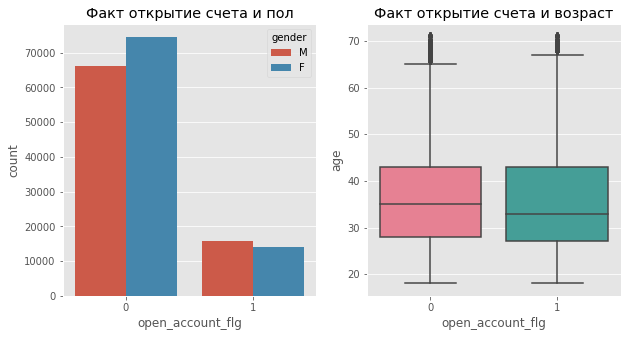

In [13]:
#Факт открт и пол
#Классы и возраст
plt.figure(figsize=(10,5))
ax = plt.subplot(1,2,1)
sns.countplot(x="open_account_flg", hue="gender", data=df, ax=ax)
plt.title('Факт открытие счета и пол')

ax = plt.subplot(1,2,2)
sns.boxplot(x="open_account_flg", y="age", palette='husl', data=df, ax=ax);
plt.title('Факт открытие счета и возраст')
plt.show()

In [ ]:
# Распределение клиентов по гендеру и по фактору открытие счета
pd.crosstab(df["open_account_flg"], df.gender)

gender,F,M
open_account_flg,,
0,74522,66168
1,14175,15881


#### Summary gender
* Всего клиентов: 170 746
* Мужины: 82049
* Женщины: 88697

* % распределение:
* Мужчины: 48.1%
* Женщины: 51.9%

* Мужчины больше открывают счет, чем женщины (кол-во женщин, которые не открыли счет выше чем мужчин) 
* Средний возраст клиентов, которые не открыли счет выше, чем у тех кто открыл счет


### Age

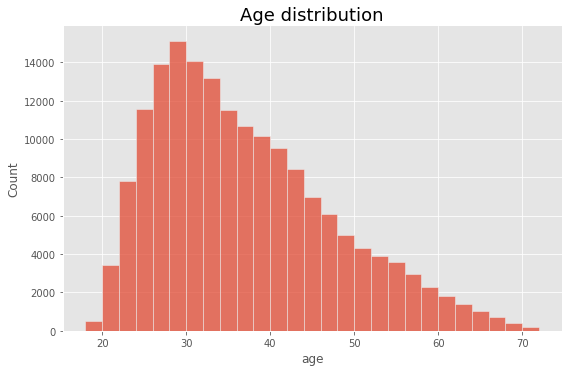

In [15]:
sns.displot(x='age', data=df, binwidth=2, height=5, aspect=1.6);
plt.title('Age distribution', fontsize=18);

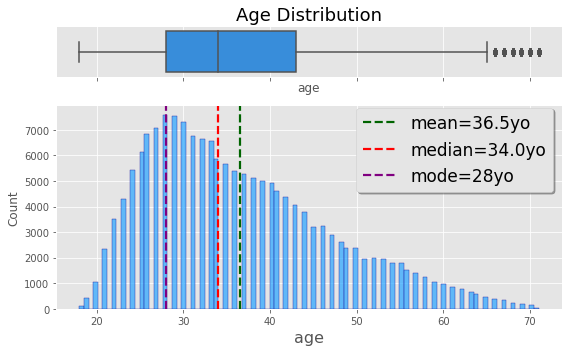

In [16]:
num_plot(df, 'age', 'Age Distribution', 'yo')

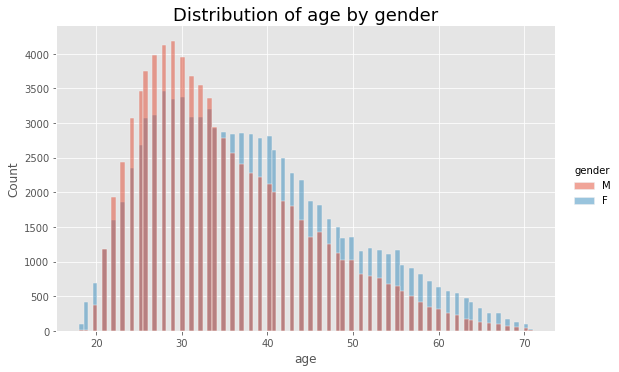

In [ ]:
sns.displot(df, x="age", hue="gender", height=5, aspect=1.6)
plt.title('Distribution of age by gender', fontsize=18);

<b>Summary: </b>В возрасте от 21-35 количество молодых людей больше чем женщин, после 35 наоборот

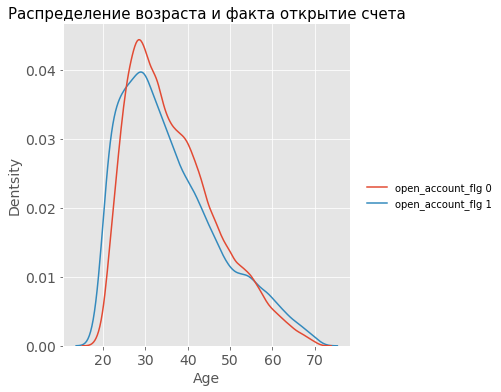

In [ ]:
sns.displot(
    {
        "open_account_flg 0": df[df.open_account_flg == 0].age,
        "open_account_flg 1": df[df.open_account_flg == 1].age
    },
    kind="kde",
    common_norm=False
)

plt.title('Распределение возраста и факта открытие счета', fontsize=15)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Dentsity', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

In [ ]:
# Процентное распредление молодых клиентов в возрасте от 20 дo 35
age_list = []
def age_distribution(df):
    for age in df['age']:
        if 20 <= age <= 35:
            age_list.append(age)

    return (len(age_list) / df.age.count())*100

print(f'Процент клиентов от 20-35: {round(age_distribution(df),2)}%')

Процент клиентов от 20-35: 53.11%


In [ ]:
# Максимальный и минимальный возраст клиентов
print(f'Max: {df.age.max()}', f'\nMin: {df.age.min()}')

Max: 71 
Min: 18


#### Age summary
* 53.11% клиентов в возрасте от 20-35 лет
* Самый молодому 18 самому старшему 71 лет
* Различие между женщинами и мужчинами в минимальных и максимальных значениях нет. Есть различие в среднем возрасте на 2 года

# Marital status

In [ ]:
# Количество клиентов по семейному положению
df['marital_status'].value_counts(dropna = False)

MAR    93956
UNM    52149
DIV    16970
CIV     4196
WID     3475
Name: marital_status, dtype: int64

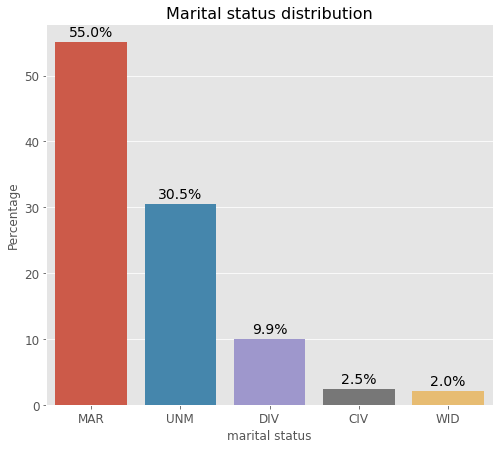

In [ ]:
#Процентное распределение клиентов по семейному положению
plotDistribution('marital_status', 'Marital status')

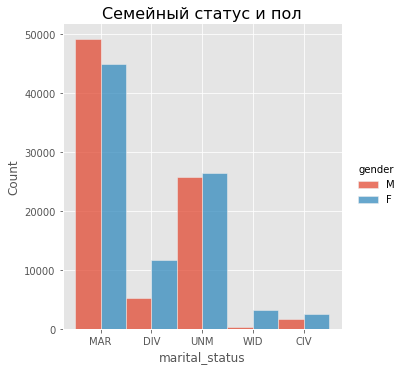

In [ ]:
sns.displot(df, x="marital_status", hue="gender", multiple="dodge")
plt.title('Семейный статус и пол', fontsize=16)
plt.show()

#### <b>Summary</b>: 
* Семейное положение
 * 55% процентов клиентов женаты/замужем
 * 30% не женаты
 * 9.9% разведены
 * 2% вдовы
* Во всех категориях кроме женатый, кол-во женщин больше чем мужчин

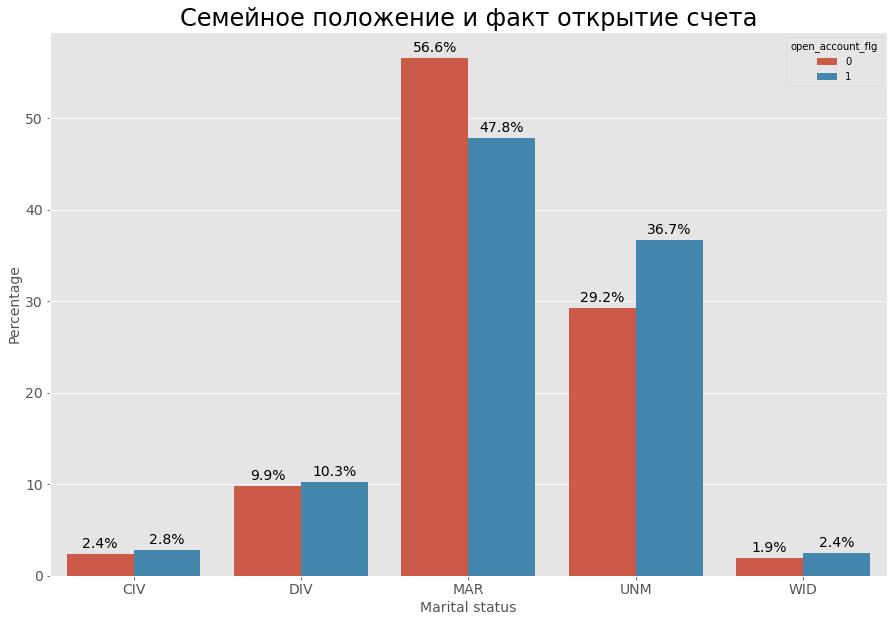

In [ ]:
plt.figure(figsize=(15, 10))

educ_def = (df.groupby(['open_account_flg'])['marital_status']
            .value_counts(normalize=True)
            .rename('percentage')
            .mul(100)
            .reset_index()
            .sort_values('marital_status'))

ax = sns.barplot(x="marital_status", y="percentage", hue="open_account_flg", data=educ_def)

for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    ax.annotate(percentage, 
                (p.get_x() + p.get_width() / 2., p.get_height()),  
                ha='center',  
                va='center',
                xytext=(0, 10),
                textcoords='offset points',  
                fontsize=14)

plt.title('Семейное положение и факт открытие счета', fontsize=24)
plt.ylabel('Percentage', fontsize=14)
plt.xlabel('Marital status', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

#### <b>Summary</b>: Если посмотреть на процентное соотношения фактического открытия счета, то семейные люди открывали счет больше, чем остальные. Но по факту открытия счета, чем не открытие, то не семейные люди больше открывали счет.

# Education

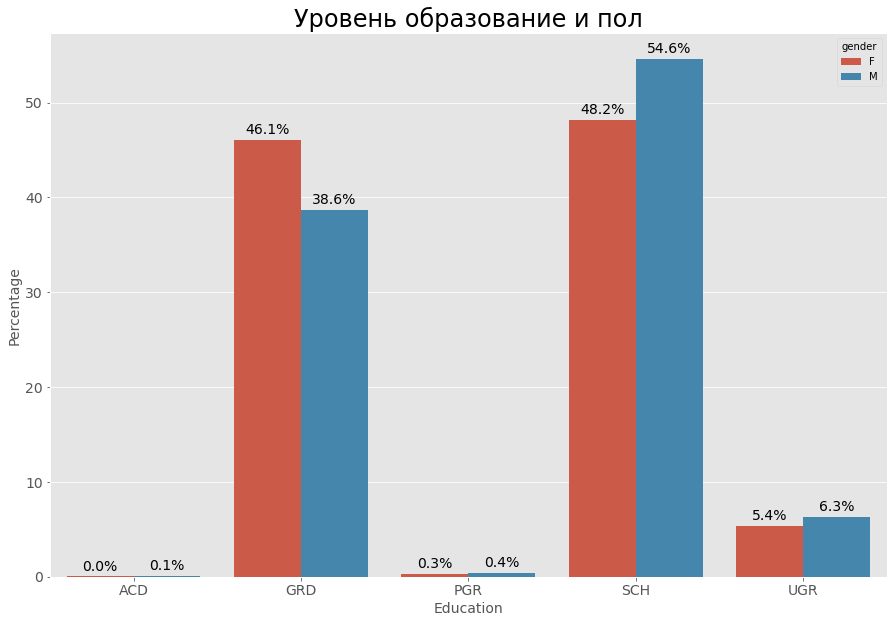

In [ ]:
plt.figure(figsize=(15, 10))

educ_def = (df.groupby(['gender'])['education']
            .value_counts(normalize=True)
            .rename('percentage')
            .mul(100)
            .reset_index()
            .sort_values('education'))

ax = sns.barplot(x="education", y="percentage", hue="gender", data=educ_def)

for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    ax.annotate(percentage, 
                (p.get_x() + p.get_width() / 2., p.get_height()),  
                ha='center',  
                va='center',
                xytext=(0, 10),
                textcoords='offset points',  
                fontsize=14)

plt.title('Уровень образование и пол', fontsize=24)
plt.ylabel('Percentage', fontsize=14)
plt.xlabel('Education', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

#### <b>Summary</b>: 
* Кол-во женщин с вышсем образованием выше, чем мужчин. 

In [18]:
# Данная функция удаляет выбросы
def remove_outliers(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

w_outliers_data = remove_outliers(df, 'monthly_income')

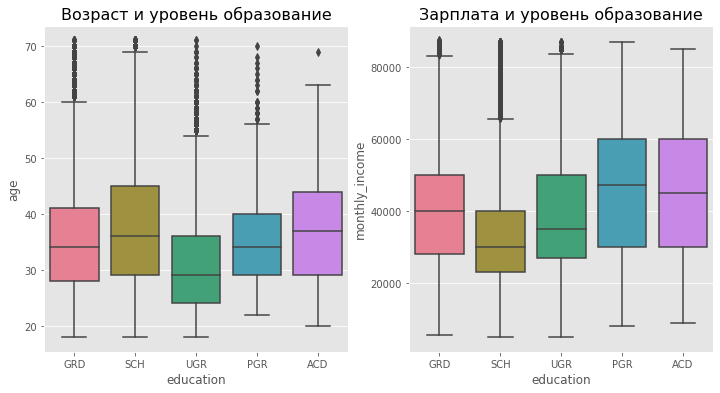

In [ ]:
plt.figure(figsize=(12,6))
ax = plt.subplot(1,2,1)
plt.title('Возраст и уровень образование', fontsize=16)
sns.boxplot(x="education", y="age", palette='husl', data=df, ax=ax)
ax = plt.subplot(1,2,2)
sns.boxplot(x="education", y="monthly_income", palette='husl', data=w_outliers_data, ax=ax)
plt.title('Зарплата и уровень образование', fontsize=16)
plt.show()

#### <b>Summary</b>: 
* Средний возраст людей с уровнем образование бакалавр, ниже чем у остальных.
* Чем ниже ступень образование тем, тем меньше средняя зарплата. Средняя зарплата у людей со школьным образованием ниже чем у всех остальных.

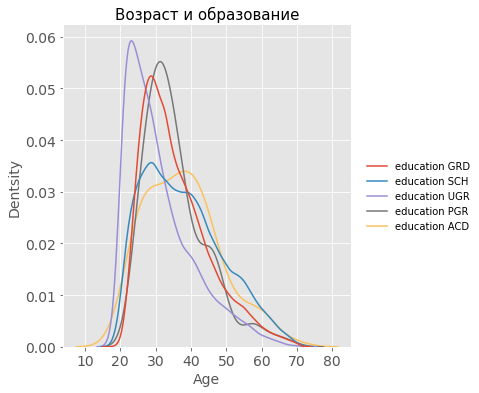

In [ ]:
sns.displot(
    {
        "education GRD": df[df.education == 'GRD'].age,
        "education SCH": df[df.education == 'SCH'].age,
        "education UGR": df[df.education == 'UGR'].age,
        "education PGR": df[df.education == 'PGR'].age,
        "education ACD": df[df.education == 'ACD'].age,
    },
    kind="kde",
    common_norm=False
)

plt.title('Возраст и образование', fontsize=15)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Dentsity', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

#### <b>Summary</b>: 
* Чаще всего молодые люди от 20-30 имеют уровень образование бакалавр

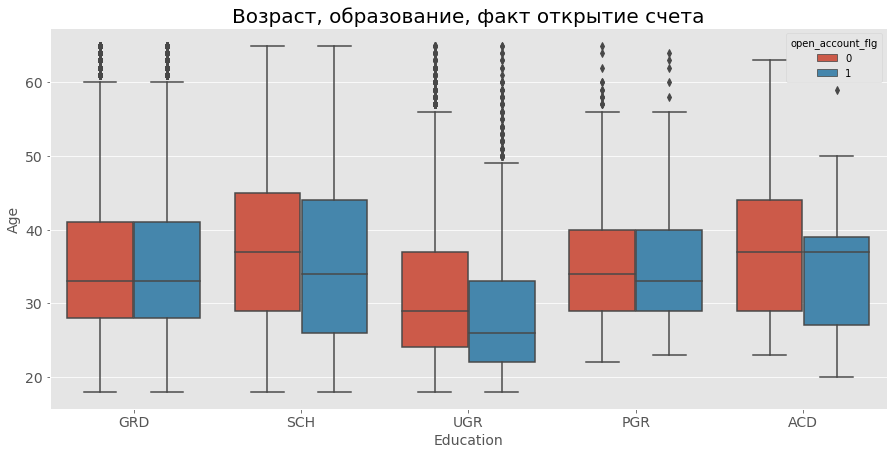

In [ ]:
plt.figure(figsize=(15, 7))

sns.boxplot(x='education', y='age', hue='open_account_flg', data=remove_outliers(df, 'age'))

plt.title('Возраст, образование, факт открытие счета', fontsize=20)
plt.ylabel('Age', fontsize=14)
plt.xlabel('Education', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

#### <b>Summary</b>: 
* Средний возраст клиентов уровень образование которых UGR и которые открывают счет ниже чем у остальных. 

#Job position

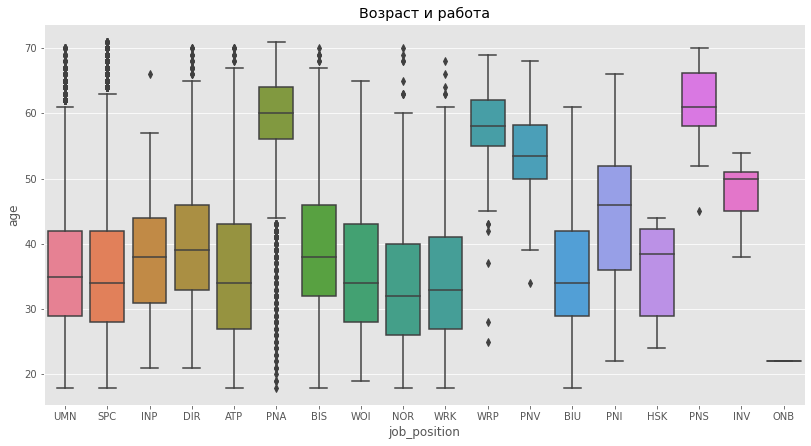

In [ ]:
plt.figure(figsize=(30,7))
ax = plt.subplot(1,2,1)
sns.boxplot(x="job_position", y="age", palette='husl', data=df, ax=ax)
plt.title('Возраст и работа')
plt.show()

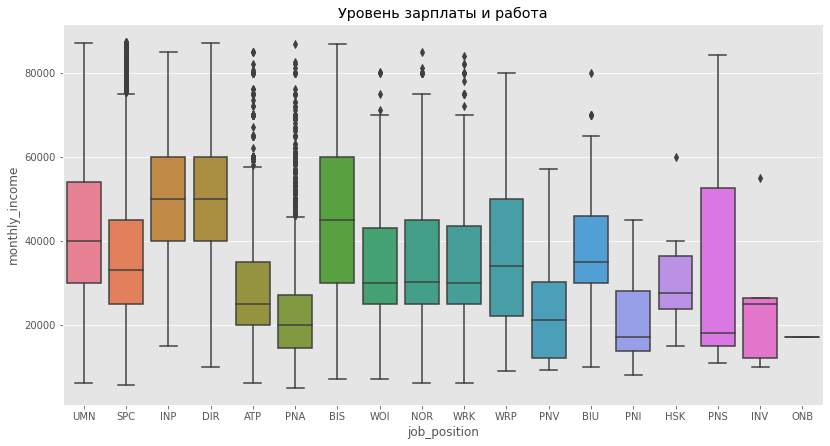

In [ ]:
plt.figure(figsize=(30,7))
ax = plt.subplot(1,2,1)
sns.boxplot(x="job_position", y="monthly_income", palette='husl', data=w_outliers_data, ax=ax)
plt.title('Уровень зарплаты и работа')
plt.show()

#### <b>Summary</b>: 
* Средний возраст безработных молодых людей 35 лет

In [ ]:
# Регионы в которых больше всего открывали счета
opened_region = pd.crosstab(df["living_region"], df.open_account_flg)
opened_region[opened_region[1]>500]

open_account_flg,0,1
living_region,,
КРАСНОДАРСКИЙ КРАЙ,5942,1515
КРАСНОЯРСКИЙ КРАЙ,2350,579
МОСКВА,4246,1283
МОСКВА Г,3035,612
ОБЛ ИРКУТСКАЯ,3186,894
ОБЛ КЕМЕРОВСКАЯ,2242,586
ОБЛ ЛЕНИНГРАДСКАЯ,2697,532
ОБЛ МОСКОВСКАЯ,10090,2138
ОБЛ НИЖЕГОРОДСКАЯ,2923,632


(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5]),
 <a list of 9 Text major ticklabel objects>)

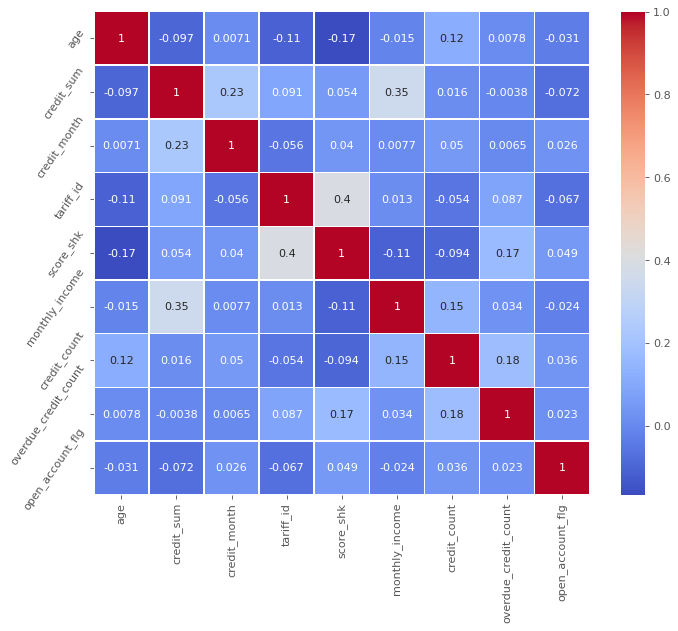

In [ ]:
plt.figure(figsize=(10,8),dpi=80)
sns.heatmap(df.corr(),cmap="coolwarm",annot=True,linewidth=0.5)
plt.yticks(rotation=55)